In [18]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import random as random 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import math

Import data

In [2]:
df = pd.read_csv("df2.csv")

In [3]:
df.shape

(589, 17)

## Modeling

In [5]:
def num_cat(df): 
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df



In [6]:
df_encoding = num_cat(df)

In [7]:
df_encoding.head()

,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,age,LoanAmountScale,TotalIncome,MonthlyPayment,DebtToIncomeRatio,Gender_Male,...,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncomeCut_2nd part,TotalIncomeCut_3rd part,TotalIncomeCut_4th part,TotalIncomeCut_5th part
0,5849,0.0,360.0,1.0,45.0,128000.0,5849.0,355.555556,0.060789,1,...,0,0,0,0,1,1,1,0,0,0
1,4583,1508.0,360.0,1.0,48.0,128000.0,6091.0,355.555556,0.058374,1,...,0,0,0,0,0,0,1,0,0,0
2,3000,0.0,360.0,1.0,34.0,66000.0,3000.0,183.333333,0.061111,1,...,0,0,1,0,1,1,0,0,0,0
3,2583,2358.0,360.0,1.0,34.0,120000.0,4941.0,333.333333,0.067463,1,...,0,1,0,0,1,1,0,0,0,0
4,6000,0.0,360.0,1.0,38.0,141000.0,6000.0,391.666667,0.065278,1,...,0,0,0,0,1,1,1,0,0,0


In [11]:
X = df_encoding.drop('Loan_Status_Y', axis=1)
y = df_encoding['Loan_Status_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1] 

print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
print("\nAUC Score :", roc_auc_score(y_test, y_proba))

Matrice de confusion :
 [[21 34]
 [65 57]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.24      0.38      0.30        55
           1       0.63      0.47      0.54       122

    accuracy                           0.44       177
   macro avg       0.44      0.42      0.42       177
weighted avg       0.51      0.44      0.46       177


AUC Score : 0.4910581222056632


In [12]:

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_rf))
print("\nAUC Score :", roc_auc_score(y_test, y_pred_rf))

Matrice de confusion :
 [[ 37  18]
 [  2 120]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.67      0.79        55
           1       0.87      0.98      0.92       122

    accuracy                           0.89       177
   macro avg       0.91      0.83      0.86       177
weighted avg       0.89      0.89      0.88       177


AUC Score : 0.828166915052161


Nombre d'arbres dans la forêt : 200
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1608637542, splitter='best')


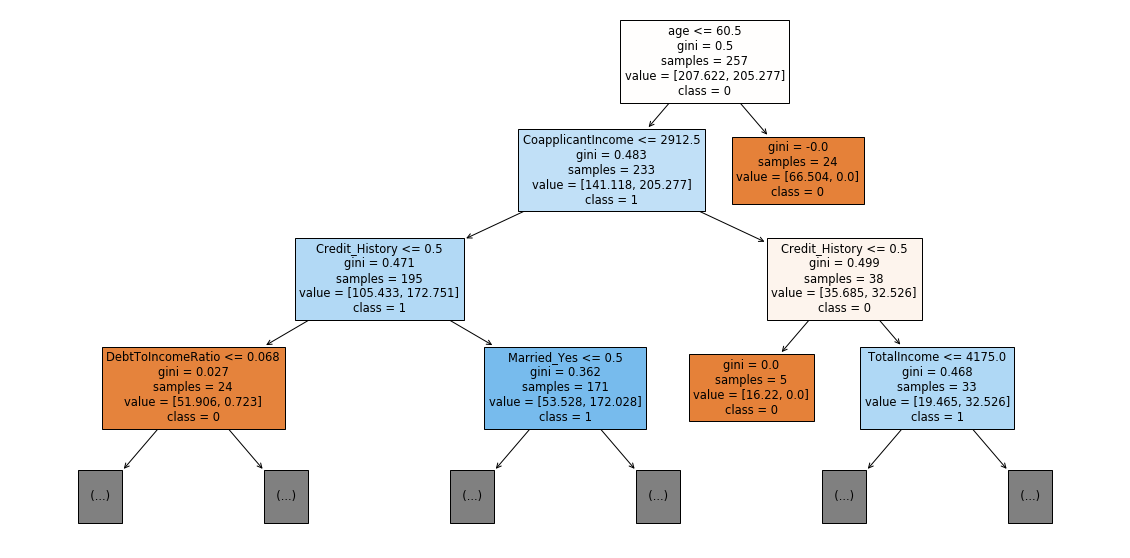

In [ ]:

arbres = rf.estimators_


print(f"Nombre d'arbres dans la forêt : {len(arbres)}")


arbre1 = arbres[0]
print(arbre1)


plt.figure(figsize=(20,10))
plot_tree(arbre1, filled=True, max_depth=3, feature_names=X_train.columns, class_names=['0', '1'])
plt.show()


In [19]:

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2', None],
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters :", random_search.best_params_)
print("Best AUC score :", random_search.best_score_)


Best parameters : {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 486}
Best AUC score : 0.8788825910931173


In [20]:

rf_optimized = RandomForestClassifier(
    n_estimators=215,
    max_depth=4,
    max_features=None,
    min_samples_leaf=7,
    min_samples_split=9,
    class_weight='balanced',
    random_state=123
)

rf_optimized.fit(X_train, y_train)

y_proba = rf_optimized.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
print("\nAUC Score :", roc_auc_score(y_test, y_proba))


Matrice de confusion :
 [[ 38  17]
 [  5 117]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.69      0.78        55
           1       0.87      0.96      0.91       122

    accuracy                           0.88       177
   macro avg       0.88      0.82      0.84       177
weighted avg       0.88      0.88      0.87       177


AUC Score : 0.8895678092399403
